<a href="https://colab.research.google.com/github/Ribhu131/Ribhu131/blob/main/Spam_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

### Change Encoding

In [ ]:
file = 'spam.csv'

In [ ]:
import chardet
with open(file, 'rb') as rawdata:
    result = chardet.detect(rawdata.read(100000))
result

{'confidence': 0.7270322499829184, 'encoding': 'Windows-1252', 'language': ''}

In [ ]:
df = pd.read_csv(file,encoding='ISO-8859-1')

### Exploratory Data Analysis

In [ ]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [ ]:
df.describe()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""","MK17 92H. 450Ppw 16""","GNT:-)"""
freq,4825,30,3,2,2


### Data Pre Processing

In [ ]:
df = df.iloc[:,:2]

In [ ]:
df.columns = ['Target','Messages']

In [ ]:
df['Target'] = df['Target'].replace('ham',0)

In [ ]:
df.head()

,Target,Messages
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
df['Target'] = df['Target'].replace('spam',1)

In [ ]:
df.head()

,Target,Messages
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
df.shape

(5572, 2)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


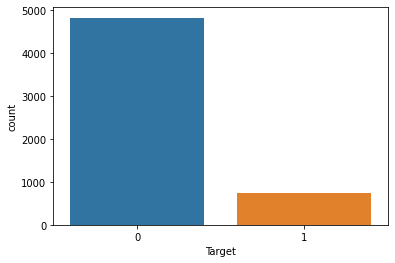

In [ ]:
sns.countplot('Target',data=df)

In [ ]:
df.head(3)

,Target,Messages
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...


In [ ]:
df['Messages']

0       Go until jurong point, crazy.. Available only ...
1                           Ok lar... Joking wif u oni...
2       Free entry in 2 a wkly comp to win FA Cup fina...
3       U dun say so early hor... U c already then say...
4       Nah I don't think he goes to usf, he lives aro...
                              ...                        
5567    This is the 2nd time we have tried 2 contact u...
5568                Will Ì_ b going to esplanade fr home?
5569    Pity, * was in mood for that. So...any other s...
5570    The guy did some bitching but I acted like i'd...
5571                           Rofl. Its true to its name
Name: Messages, Length: 5572, dtype: object

### Cleaning The Text

In [ ]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

corpus = []
for i in range(0,5572):
    review = re.sub('[^a-zA-Z]',' ', df['Messages'][i])
    review = review.lower()
    review = review.split()
    ps = PorterStemmer()
    all_stopword = stopwords.words('english')
    all_stopword.remove('not')
    review = [ps.stem(word) for word in review if not word in set(all_stopword)]
    review = ' '.join(review)
    corpus.append(review)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
print(corpus)

['go jurong point crazi avail bugi n great world la e buffet cine got amor wat', 'ok lar joke wif u oni', 'free entri wkli comp win fa cup final tkt st may text fa receiv entri question std txt rate c appli', 'u dun say earli hor u c alreadi say', 'nah think goe usf live around though', 'freemsg hey darl week word back like fun still tb ok xxx std chg send rcv', 'even brother not like speak treat like aid patent', 'per request mell mell oru minnaminungint nurungu vettam set callertun caller press copi friend callertun', 'winner valu network custom select receivea prize reward claim call claim code kl valid hour', 'mobil month u r entitl updat latest colour mobil camera free call mobil updat co free', 'gonna home soon want talk stuff anymor tonight k cri enough today', 'six chanc win cash pound txt csh send cost p day day tsandc appli repli hl info', 'urgent week free membership prize jackpot txt word claim c www dbuk net lccltd pobox ldnw rw', 'search right word thank breather promis w

### Creating Bag of Words

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features = 2000)
X = cv.fit_transform(corpus).toarray()
y = df.iloc[:,0].values

In [ ]:
len(X[0])

2000

In [ ]:
len(y)

5572

### Splitting the dataset into the Training set and Test set

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=0)

## **Model Building**

### Logistic Regression

In [ ]:
classifier = LogisticRegression()
classifier.fit(X_train,y_train)
y_lr=classifier.predict(X_test)
print('Confusion Matrix \n',confusion_matrix(y_lr,y_test))
print()
print('Accuracy Score \n', accuracy_score(y_lr,y_test))
print()
print('Classification Report \n',classification_report(y_lr,y_test))

Confusion Matrix 
 [[1194   27]
 [   2  170]]

Accuracy Score 
 0.9791816223977028

Classification Report 
               precision    recall  f1-score   support

           0       1.00      0.98      0.99      1221
           1       0.86      0.99      0.92       172

    accuracy                           0.98      1393
   macro avg       0.93      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393



### Support Vector Classifier

In [ ]:
classifier = SVC()
classifier.fit(X_train,y_train)
y_svc=classifier.predict(X_test)
('Confusion Matrix \n',confusion_matrix(y_svc,y_test))
print()
print('Accuracy Score \n', accuracy_score(y_svc,y_test))
print()
print('Classification Report \n',classification_report(y_svc,y_test))


Accuracy Score 
 0.9784637473079684

Classification Report 
               precision    recall  f1-score   support

           0       1.00      0.98      0.99      1224
           1       0.85      0.99      0.92       169

    accuracy                           0.98      1393
   macro avg       0.93      0.99      0.95      1393
weighted avg       0.98      0.98      0.98      1393



### Decision Tree

In [ ]:
classifier = DecisionTreeClassifier()
classifier.fit(X_train,y_train)
y_tree=classifier.predict(X_test)

print('Confusion Matrix \n',confusion_matrix(y_tree,y_test))
print()
print('Accuracy Score \n', accuracy_score(y_tree,y_test))
print()
print('Classification Report \n',classification_report(y_tree,y_test))

Confusion Matrix 
 [[1186   28]
 [  10  169]]

Accuracy Score 
 0.9727207465900933

Classification Report 
               precision    recall  f1-score   support

           0       0.99      0.98      0.98      1214
           1       0.86      0.94      0.90       179

    accuracy                           0.97      1393
   macro avg       0.92      0.96      0.94      1393
weighted avg       0.97      0.97      0.97      1393



### Naive Bayes

In [ ]:
classifier = GaussianNB()
classifier.fit(X_train,y_train)
y_gb=classifier.predict(X_test)

print('Confusion Matrix \n',confusion_matrix(y_gb,y_test))
print()
print('Accuracy Score \n', accuracy_score(y_gb,y_test))
print()
print('Classification Report \n',classification_report(y_gb,y_test))

Confusion Matrix 
 [[1014   23]
 [ 182  174]]

Accuracy Score 
 0.8528356066044508

Classification Report 
               precision    recall  f1-score   support

           0       0.85      0.98      0.91      1037
           1       0.88      0.49      0.63       356

    accuracy                           0.85      1393
   macro avg       0.87      0.73      0.77      1393
weighted avg       0.86      0.85      0.84      1393



### K Nearest Neighbour

In [ ]:
classifier = KNeighborsClassifier()
classifier.fit(X_train,y_train)
y_nb = classifier.predict(X_test)
 
print('Confusion Matrix \n',confusion_matrix(y_nb,y_test))
print()
print('Accuracy Score \n', accuracy_score(y_nb,y_test))
print()
print('Classification Report \n',classification_report(y_nb,y_test))

Confusion Matrix 
 [[1196  115]
 [   0   82]]

Accuracy Score 
 0.9174443646805456

Classification Report 
               precision    recall  f1-score   support

           0       1.00      0.91      0.95      1311
           1       0.42      1.00      0.59        82

    accuracy                           0.92      1393
   macro avg       0.71      0.96      0.77      1393
weighted avg       0.97      0.92      0.93      1393



### Random Forest

In [ ]:
classifier = RandomForestClassifier()
classifier.fit(X_train,y_train)
y_rfc=classifier.predict(X_test)

print('Confusion Matrix \n',confusion_matrix(y_rfc,y_test))
print()
print('Accuracy Score \n', accuracy_score(y_rfc,y_test))
print()
print('Classification Report \n',classification_report(y_rfc,y_test))

Confusion Matrix 
 [[1195   24]
 [   1  173]]

Accuracy Score 
 0.9820531227566404

Classification Report 
               precision    recall  f1-score   support

           0       1.00      0.98      0.99      1219
           1       0.88      0.99      0.93       174

    accuracy                           0.98      1393
   macro avg       0.94      0.99      0.96      1393
weighted avg       0.98      0.98      0.98      1393



In [ ]:
mylist = np.concatenate((y_rfc.reshape(len(y_rfc),1), y_test.reshape(len(y_test),1)),1)

In [ ]:
mylist

array([[0, 0],
       [0, 0],
       [0, 0],
       ...,
       [0, 0],
       [0, 0],
       [1, 1]])

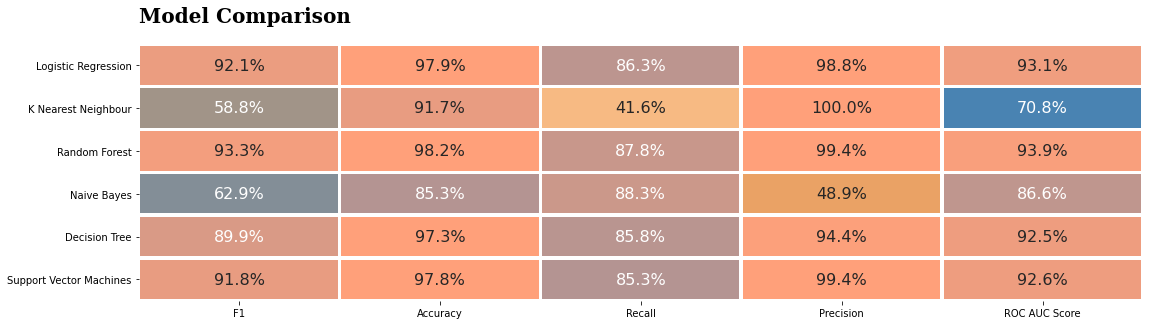

In [ ]:
lr_df = pd.DataFrame(data=[f1_score(y_test,y_lr),accuracy_score(y_test, y_lr), recall_score(y_test, y_lr), precision_score(y_test, y_lr), roc_auc_score(y_test, y_lr)], 
             columns=['Logistic Regression'], index=["F1","Accuracy", "Recall", "Precision", "ROC AUC Score"])

knb_df = pd.DataFrame(data=[f1_score(y_test,y_nb),accuracy_score(y_test, y_nb), recall_score(y_test, y_nb), precision_score(y_test, y_nb), roc_auc_score(y_test, y_nb)], 
             columns=['K Nearest Neighbour'], index=["F1","Accuracy", "Recall", "Precision", "ROC AUC Score"])

svc_df = pd.DataFrame(data=[f1_score(y_test,y_svc),accuracy_score(y_test, y_svc), recall_score(y_test, y_svc), precision_score(y_test, y_svc), roc_auc_score(y_test,y_svc)], 
             columns=['Support Vector Machines'], index=["F1","Accuracy", "Recall", "Precision", "ROC AUC Score"])

dt_df = pd.DataFrame(data=[f1_score(y_test,y_tree),accuracy_score(y_test, y_tree), recall_score(y_test, y_tree), precision_score(y_test, y_tree), roc_auc_score(y_test, y_tree)], 
             columns=['Decision Tree'], index=["F1","Accuracy", "Recall", "Precision", "ROC AUC Score"])

nb_df = pd.DataFrame(data=[f1_score(y_test,y_gb),accuracy_score(y_test, y_gb), recall_score(y_test, y_gb), precision_score(y_test, y_gb), roc_auc_score(y_test, y_gb)], 
             columns=['Naive Bayes'], index=["F1","Accuracy", "Recall", "Precision", "ROC AUC Score"])
			 
rf_df = pd.DataFrame(data=[f1_score(y_test,y_rfc),accuracy_score(y_test, y_rfc), recall_score(y_test, y_rfc),precision_score(y_test, y_rfc), roc_auc_score(y_test, y_rfc)], 
             columns=['Random Forest'],index=["F1","Accuracy", "Recall", "Precision", "ROC AUC Score"])


df_models = round(pd.concat([lr_df,knb_df,rf_df,nb_df,dt_df,svc_df], axis=1),3)
colors = ["bisque","ivory","sandybrown","steelblue","lightsalmon"]
colormap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)

background_color = "white"

fig = plt.figure(figsize=(18,26)) # create figure
gs = fig.add_gridspec(4, 2)
gs.update(wspace=0.1, hspace=0.5)
ax0 = fig.add_subplot(gs[0, :])

sns.heatmap(df_models.T, cmap=colormap,annot=True,fmt=".1%",vmin=0,vmax=0.95, linewidths=2.5,cbar=False,ax=ax0,annot_kws={"fontsize":16})
fig.patch.set_facecolor(background_color) # figure background color
ax0.set_facecolor(background_color) 

ax0.text(0,-0.5,'Model Comparison',fontsize=20,fontweight='bold',fontfamily='serif')
plt.show()